In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetB2

In [2]:
directory_root = "Dataset"
print(len(listdir(directory_root)))

26


In [3]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:

img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))


                                          image_path  \
0  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
1  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
2  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
3  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
4  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   

                                               label  
0  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
1  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
2  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
3  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
4  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
26591


In [5]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
26586,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,25
26587,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,25
26588,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,25
26589,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,25
26590,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,25


In [6]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.ANTIALIAS)  
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))

C:\Users\jobin\AppData\Local\Temp\ipykernel_39448\2472196027.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, PIL.Image.ANTIALIAS)


26591


In [7]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(26591, 64, 64, 3)


In [8]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=len(listdir(directory_root)))
print(Y.shape, Y_one_hot.shape)

(26591,) (26591, 26)


In [9]:
"""
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)
"""

'\nnp.savez("x_images_arrayscnn", X)\nnp.savez("y_numeric_labelscnn", Y_one_hot)\n'

In [10]:
"""
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)
"""

'\nx_npz = np.load("x_images_arrayscnn.npz")\nX = x_npz[\'arr_0\']\n\ny_npz = np.load("y_numeric_labelscnn.npz")\nY_one_hot = y_npz[\'arr_0\']\n\nprint(X.shape)\n'

In [11]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(21272, 64, 64, 3) (2659, 64, 64, 3) (2660, 64, 64, 3) (21272, 26) (2659, 26) (2660, 26)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = len(listdir(directory_root))

model = models.Sequential()
model.add(EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape, drop_connect_rate=0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                              factor=0.2,
                                              mode="min",
                                              min_lr=1e-6,
                                              patience=2,
                                              verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min",
                                         patience=3,
                                         verbose=1,
                                         restore_best_weights=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 2, 2, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 26)                6

Training model...
Epoch 1/100



333/333 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7710
Epoch 1: val_loss improved from inf to 4.83614, saving model to efnetb3_m2_h5.h5


c:\Users\jobin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 197s 510ms/step - loss: 0.7572 - accuracy: 0.7710 - val_loss: 4.8361 - val_accuracy: 0.0320 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9050
Epoch 2: val_loss did not improve from 4.83614
333/333 [==============================] - 162s 486ms/step - loss: 0.2914 - accuracy: 0.9050 - val_loss: 7.6097 - val_accuracy: 0.0778 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9408
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_loss did not improve from 4.83614
333/333 [==============================] - 166s 499ms/step - loss: 0.1897 - accuracy: 0.9408 - val_loss: 8.7876 - val_accuracy: 0.0790 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9737
Epoch 4: val_loss improved from 4.83614 to 1.78167, saving model to efnetb3_m2_h5.h5
333/333 

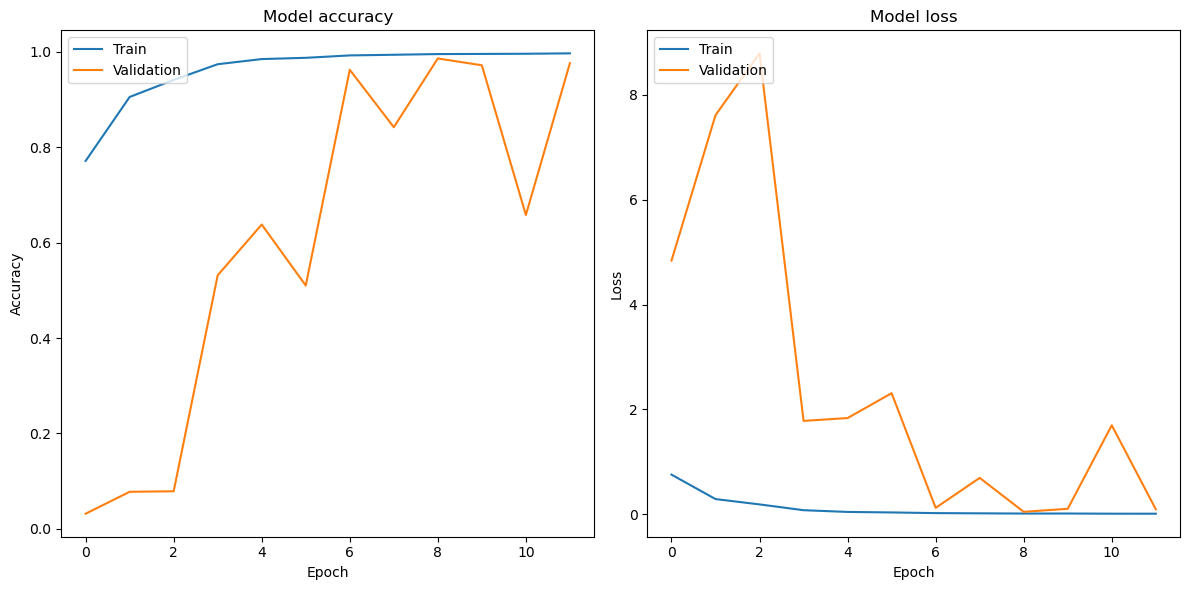

INFO:tensorflow:Assets written to: C:\Users\jobin\AppData\Local\Temp\tmpx_3df2om\assets


INFO:tensorflow:Assets written to: C:\Users\jobin\AppData\Local\Temp\tmpx_3df2om\assets


84/84 [==============================] - 8s 100ms/step - loss: 0.0629 - accuracy: 0.9797
Test Loss: 0.06291396915912628
Test Accuracy: 0.9796992540359497
84/84 [==============================] - 10s 98ms/step
Confusion Matrix:
[[144   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  2 190   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0 161   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  1   0   0 178   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0  33   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  45   0   4   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1  32   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


# Model Checkpoint
best_model_file = "efnetb3_m2_h5.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[rlronp, estop, best_model]
)

print('Training finished.')

# Visualize training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = load_model(best_model_file)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_file = "efnetb3_m2_tflite.tflite"
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)


# Evaluate the best model on the test set
model.evaluate(X_test, Y_test)

# Evaluate the best model on the test set and compute accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(Y_true_labels, Y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_true_labels, Y_pred_labels))


In [15]:
'''import tensorflow as tf

def convert_h5_to_tflite(h5_path, tflite_path):
    # Load the model from the HDF5 file
    model = tf.keras.models.load_model(h5_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model to a file
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

# Specify the paths for your HDF5 and TFLite files
h5_file_path = 'efficientnetb3_model.h5'
tflite_file_path = 'efficientnetb3tflite.tflite'

# Call the function to convert the HDF5 model to TFLite
convert_h5_to_tflite(h5_file_path, tflite_file_path)
'''

"import tensorflow as tf\n\ndef convert_h5_to_tflite(h5_path, tflite_path):\n    # Load the model from the HDF5 file\n    model = tf.keras.models.load_model(h5_path)\n\n    # Convert the model to TensorFlow Lite format\n    converter = tf.lite.TFLiteConverter.from_keras_model(model)\n    tflite_model = converter.convert()\n\n    # Save the TFLite model to a file\n    with open(tflite_path, 'wb') as f:\n        f.write(tflite_model)\n\n# Specify the paths for your HDF5 and TFLite files\nh5_file_path = 'efficientnetb3_model.h5'\ntflite_file_path = 'efficientnetb3tflite.tflite'\n\n# Call the function to convert the HDF5 model to TFLite\nconvert_h5_to_tflite(h5_file_path, tflite_file_path)\n"

In [16]:
'''import tensorflow as tf
from PIL import Image

def load_and_preprocess_image(image_path, input_shape):
    # Load the image using PIL
    img = Image.open(image_path)
    
    # Resize the image to match the expected input shape
    img = img.resize((input_shape[1], input_shape[2]))
    
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Expand the dimensions to create a batch of size 1
    img_array = tf.expand_dims(img_array, 0)
    
    return img_array

def predict_image_class(image_path, interpreter):
    # Load and preprocess the image
    input_details = interpreter.get_input_details()
    input_shape = input_details[0]['shape']
    img = load_and_preprocess_image(image_path, input_shape)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_details = interpreter.get_output_details()
    output = interpreter.get_tensor(output_details[0]['index'])

    # Process the output (assuming classification task)
    predicted_class = tf.argmax(output[0]).numpy()

    return predicted_class

# Specify the paths for your TFLite model and input image
tflite_model_path = 'efficientnetb3tflite.tflite'
image_path = 'leafcurl.jpg'

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Call the function to predict the class of the input image
predicted_class = predict_image_class(image_path, interpreter)
print("Predicted Class:", predicted_class)
'''

'import tensorflow as tf\nfrom PIL import Image\n\ndef load_and_preprocess_image(image_path, input_shape):\n    # Load the image using PIL\n    img = Image.open(image_path)\n    \n    # Resize the image to match the expected input shape\n    img = img.resize((input_shape[1], input_shape[2]))\n    \n    # Convert the image to a NumPy array\n    img_array = tf.keras.preprocessing.image.img_to_array(img)\n    \n    # Expand the dimensions to create a batch of size 1\n    img_array = tf.expand_dims(img_array, 0)\n    \n    return img_array\n\ndef predict_image_class(image_path, interpreter):\n    # Load and preprocess the image\n    input_details = interpreter.get_input_details()\n    input_shape = input_details[0][\'shape\']\n    img = load_and_preprocess_image(image_path, input_shape)\n\n    # Set the input tensor\n    interpreter.set_tensor(input_details[0][\'index\'], img)\n\n    # Run the inference\n    interpreter.invoke()\n\n    # Get the output tensor\n    output_details = interpre